# Imports
We need pandas for loading csv into dataframes. torch is need for datasets.
skimage is need to read images and also to transform them. numpy is need for numeric operations
like slicing, rescale. matplotlib is needed for general ploting. os is needed for some file operations

In [47]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# Load data
Data from csv is read into a dataframe. First column is name of the image and remaining columns correspond
to x and y values of facial landmarks. For columns [1:], we can convert those to array and reshape into [?, 2]
This is the most fundamental operation in loading the data, followed by some matrix transforms

In [51]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')
print ('Size of datset : {} images'.format(landmarks_frame.size))

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Size of datset : 9453 images
Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


In [54]:
x = io.imread(os.path.join('data/faces/', img_name))

# skimage.imread
This utiliyt function can read an image into W*H*C .
This needs to be transposed for CNN models since C is typically the first dimension
in many CNN architectures. We read the image data and pass it into show_landmarks
which use imshow to show image and later apply scatter plot on it.

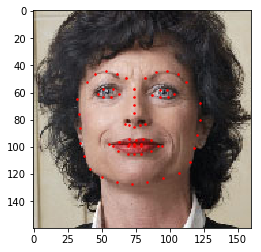

In [35]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

# Torch utils Dataset
We implement FaceLandmarksDataset by inheriting from Dataset. We inherit from
torch.utils.data.datset so that we can make use of other functions later. __init__
is the ocnstructor. __len__ will enable len() call on the object and __getitem__
will help enable [] operator. Together, this class will let us iterate on our datasset
using imread and getting landmarks from our dataframe.

In [36]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

## Use FaceLandmarksDataset example
We simply iterate using the Dataset implemented above and we print the idx and
shapes of the image, landmarks. We also display the sample using __show_landmarks()__
On.y first 4 examples are show. It is worth noting that different examples have different sizes.

0 (324, 215, 3) (68, 2)


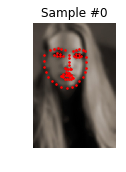

1 (500, 333, 3) (68, 2)


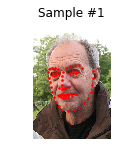

2 (250, 258, 3) (68, 2)


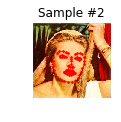

3 (434, 290, 3) (68, 2)


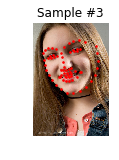

In [39]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

# Implement Rescale class
It is intentional to implement the operation as a class so that it is callable
as opposefd to doing a function with parameters. Also it helps in passing
the object to transform which is widely used with Dataset

In [40]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

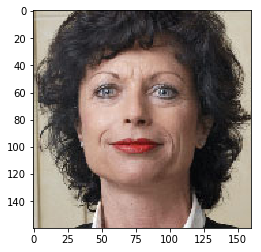

In [66]:
scale = Rescale(256)
x = io.imread(os.path.join('data/faces/', img_name))
plt.imshow(x)

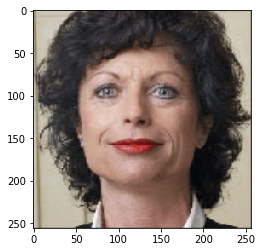

In [68]:
x_rescaled = scale({'image':x,'landmarks':np.array([1, 1])})
plt.imshow(x_rescaled['image'])

# Implement RandomCrop
This is also very similar to Rescale where we pass similar arguments as either int or tuple.
A random section is cropped by simple random number generation and cropping the volume out

In [41]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

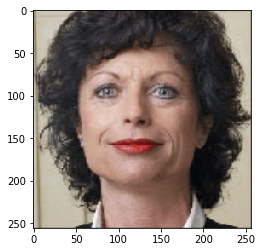

In [69]:
crop = RandomCrop(75)
plt.imshow(x_rescaled['image'])

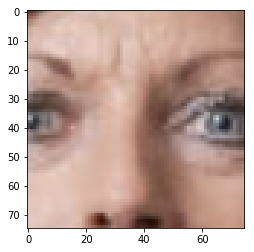

In [70]:
x_cropped = crop(x_rescaled)
plt.imshow(x_cropped['image'])

# Implement ToTensor
This is a relatively simple operation where we transpose the image and
convert into torch tensor format for training purposes. Transpose is
needed because CNNs typically expect CxHxW tensors. So in transforms we need
dim-2 , followed by dim-0 and dim-1 because imread gives HxWxC

In [71]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

# Create transform
We chain all the above functions using transforms.Compose
and we apply individual operations and also the transform

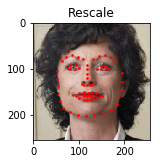

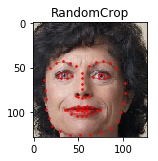

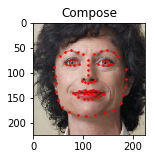

In [43]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

# Verify dataset
Now we have verified the dataset and it is all good for use with many standard
models since it is 3x224x224

In [44]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


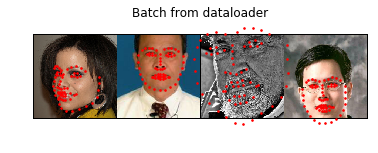

In [45]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break